In [191]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../..')

from heat_load_calc import solar_position
from heat_load_calc.region import Region
from heat_load_calc.interval import Interval

# solar_position

## outline

経度・緯度を指定して太陽高度・太陽方位角を取得する。

## Interface

weather.solar_position(phi_loc, lambda_loc, interval)

params:

| パラメータ名　| 型 | 単位 | 概要 |
| :--- | :--- | :--- | :-- |
| phi_loc | float | rad | 緯度 |
| lambda_loc | float | rad | 経度 |
| interval | str | - | 計算間隔 |

計算間隔はそれぞれ次のように文字列で指定します。  
- '1h': 1時間間隔
- '30m': 30分間隔
- '15m': 15分間隔

returns:

(np.ndarray, np.ndarray)

太陽高度(rad)と太陽方位角(rad)をタプルで返します。
それぞれのタプルはnumpy形式で、1年間のステップ数の配列になっています。


| 名称 | 単位 | 概要 |
| :--- | :--- | :--- |
| 太陽高度 | rad | 太陽高度。1年間のステップ数分の配列。np.ndarray 形式。 |
| 太陽方位角 | rad | 太陽方位角。1年間のステップ数分の配列。np.ndarray 形式。 |

## Example

In [192]:
h_sun, a_sun = solar_position.calc_solar_position(phi_loc=0.8, lambda_loc= 2.4, interval=Interval.M15)

太陽高度, rad

In [193]:
h_sun

array([-1.17188212, -1.16527529, -1.15199502, ..., -1.15231289,
       -1.16611674, -1.1732676 ])

太陽方位角, rad

In [194]:
a_sun

array([-3.07294897, -2.91987001, -2.7730727 , ...,  2.76117046,
        2.9077532 ,  3.0609659 ])

2日分の太陽高度と太陽方位角を描画する。その際、時間間隔を、15分・30分・1時間でそれぞれ計算し、計算結果が一致していることも確認する。

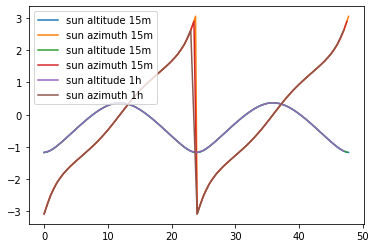

In [195]:
h_sun_15m, a_sun_15m = solar_position.calc_solar_position(phi_loc=0.8, lambda_loc= 2.4, interval=Interval.M15)
h_sun_30m, a_sun_30m = solar_position.calc_solar_position(phi_loc=0.8, lambda_loc= 2.4, interval=Interval.M30)
h_sun_1h, a_sun_1h = solar_position.calc_solar_position(phi_loc=0.8, lambda_loc= 2.4, interval=Interval.H1)

x_15m = np.arange(192)/4.0
plt.plot(x_15m, h_sun_15m[0: 192], label='sun altitude 15m')
plt.plot(x_15m, a_sun_15m[0: 192], label='sun azimuth 15m')

x_30m = np.arange(96)/2.0
plt.plot(x_30m, h_sun_30m[0: 96], label='sun altitude 15m')
plt.plot(x_30m, a_sun_30m[0: 96], label='sun azimuth 15m')

x_1h = np.arange(48)/1.0
plt.plot(x_1h, h_sun_1h[0: 48], label='sun altitude 1h')
plt.plot(x_1h, a_sun_1h[0: 48], label='sun azimuth 1h')

plt.legend()
plt.show()

## Basis

地域は1から8地域を設定する。

In [196]:
regions = [
    Region.Region1,
    Region.Region2,
    Region.Region3,
    Region.Region4,
    Region.Region5,
    Region.Region6,
    Region.Region7,
    Region.Region8
]

緯度・経度を求める。単位：radian

In [197]:
def get_phi_loc(region: Region):
    phi_loc, _ = region.get_phi_loc_and_lambda_loc()
    return phi_loc
def get_lambda_loc(region: Region):
    _, lambda_loc = region.get_phi_loc_and_lambda_loc()
    return lambda_loc

phi_loc = np.array([get_phi_loc(r) for r in regions]).reshape(-1, 1)

lambda_loc = np.array([get_lambda_loc(r) for r in regions]).reshape(-1, 1)

phi_loc, lambda_loc

(array([[0.76480328],
        [0.75415677],
        [0.69289571],
        [0.6398377 ],
        [0.63791784],
        [0.60493112],
        [0.55745816],
        [0.4574508 ]]),
 array([[2.51170333],
        [2.47470235],
        [2.46388131],
        [2.41204503],
        [2.44119202],
        [2.33734493],
        [2.2937117 ],
        [2.22852366]]))

標準子午線(meridian)(rad)を求める。

In [198]:
lambda_loc_mer = solar_position._get_lambda_loc_mer()
lambda_loc_mer

2.356194490192345

年通算日を計算する。値は1/1を1とし、12/31を365とする。

In [199]:
d_ns = solar_position._get_d_ns(interval=Interval.M15)
d_ns

array([  1,   1,   1, ..., 365, 365, 365])

1968年との年差

In [200]:
n = solar_position._get_n()
n

21

平均軌道上の近日点通過日（暦表時による1968年1月1日正午基準の日差）, d

In [201]:
d_0 = solar_position._get_d_0(n=n)
d_0

3.1616

ステップnにおける平均近点離角, rad * 365 * 96

In [202]:
m_ns = solar_position._get_m_ns(d_ns=d_ns, d_0=d_0)
m_ns

array([-0.03718378, -0.03718378, -0.03718378, ...,  6.22433392,
        6.22433392,  6.22433392])

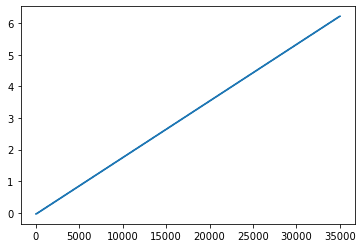

In [203]:
plt.plot(m_ns)

ステップnにおける近日点と冬至点の角度, rad * 365 * 96

In [204]:
epsilon_ns = solar_position._get_epsilon_ns(m_ns=m_ns, n=n)
epsilon_ns

array([0.22255039, 0.22255039, 0.22255039, ..., 0.22284955, 0.22284955,
       0.22284955])

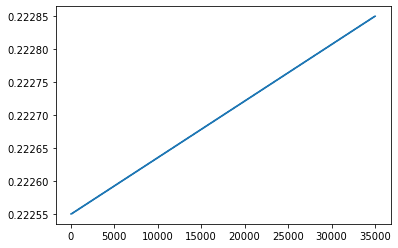

In [205]:
plt.plot(epsilon_ns)

ステップnにおける真近点離角, rad * 365 * 96

In [206]:
v_ns = solar_position._get_v_ns(m_ns=m_ns)
v_ns

array([-0.03845158, -0.03845158, -0.03845158, ...,  6.2223281 ,
        6.2223281 ,  6.2223281 ])

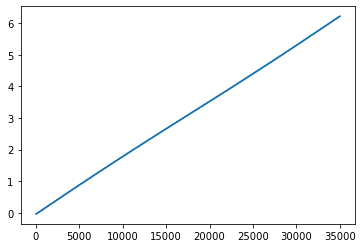

In [207]:
plt.plot(v_ns)

ステップnにおける均時差, rad * 365 * 96

In [208]:
e_t_ns = solar_position._get_e_t_ns(m_ns=m_ns, epsilon_ns=epsilon_ns, v_ns=v_ns)
e_t_ns

array([-0.01485485, -0.01485485, -0.01485485, ..., -0.01226382,
       -0.01226382, -0.01226382])

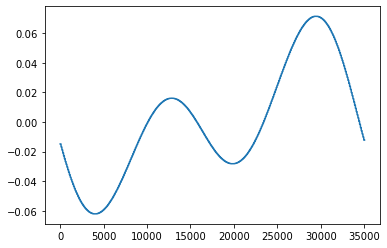

In [209]:
plt.plot(e_t_ns)

赤緯, rad * 8760 * 96

In [210]:
delta_ns = solar_position._get_delta_ns(epsilon_ns=epsilon_ns, v_ns=v_ns)

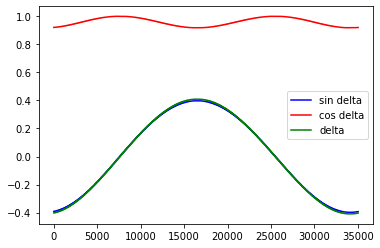

In [211]:
plt.plot(np.sin(delta_ns), 'b', label='sin delta')
plt.plot(np.cos(delta_ns), 'r', label='cos delta')
plt.plot(delta_ns, 'g', label='delta')
plt.legend()
plt.show()

ステップnにおける標準時, d * 365 * 96  
ndarray[ 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, .... , 23.75, 0, 0.25, ...23.75 ]

In [212]:
t_m_ns = solar_position._get_t_m_ns(interval=Interval.M15)
t_m_ns

array([ 0.  ,  0.25,  0.5 , ..., 23.25, 23.5 , 23.75])

ステップnにおける時角, rad * 365 * 96

In [213]:
omega_ns = solar_position._get_omega_ns(t_m_ns=t_m_ns, lambda_loc=lambda_loc, lambda_loc_mer=lambda_loc_mer, e_t_ns=e_t_ns)
omega_ns

array([[-3.00093867, -2.93548882, -2.87003898, ...,  3.08848813,
         3.15393798,  3.21938782],
       [-3.03793965, -2.9724898 , -2.90703996, ...,  3.05148715,
         3.116937  ,  3.18238684],
       [-3.04876069, -2.98331085, -2.917861  , ...,  3.04066611,
         3.10611596,  3.1715658 ],
       ...,
       [-3.17529706, -3.10984722, -3.04439737, ...,  2.91412974,
         2.97957959,  3.04502943],
       [-3.21893029, -3.15348045, -3.0880306 , ...,  2.87049651,
         2.93594635,  3.0013962 ],
       [-3.28411834, -3.21866849, -3.15321865, ...,  2.80530846,
         2.87075831,  2.93620815]])

太陽高度, rad * 8760 * 96

In [214]:
h_s_ns = solar_position._get_h_sun_ns(phi_loc, omega_ns, delta_ns)
h_s_2_ns = np.clip(h_s_ns, 0.0, None)

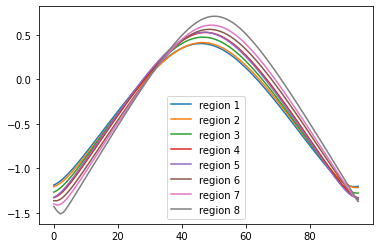

In [215]:
plt.plot(h_s_ns[0][0:96], label='region 1')
plt.plot(h_s_ns[1][0:96], label='region 2')
plt.plot(h_s_ns[2][0:96], label='region 3')
plt.plot(h_s_ns[3][0:96], label='region 4')
plt.plot(h_s_ns[4][0:96], label='region 5')
plt.plot(h_s_ns[5][0:96], label='region 6')
plt.plot(h_s_ns[6][0:96], label='region 7')
plt.plot(h_s_ns[7][0:96], label='region 8')
plt.legend()
plt.show()

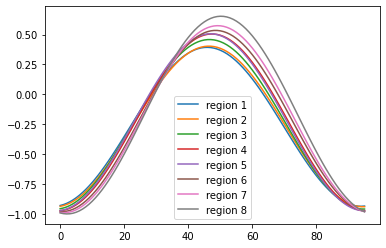

In [216]:
plt.plot(np.sin(h_s_ns)[0][0:96], label='region 1')
plt.plot(np.sin(h_s_ns)[1][0:96], label='region 2')
plt.plot(np.sin(h_s_ns)[2][0:96], label='region 3')
plt.plot(np.sin(h_s_ns)[3][0:96], label='region 4')
plt.plot(np.sin(h_s_ns)[4][0:96], label='region 5')
plt.plot(np.sin(h_s_ns)[5][0:96], label='region 6')
plt.plot(np.sin(h_s_ns)[6][0:96], label='region 7')
plt.plot(np.sin(h_s_ns)[7][0:96], label='region 8')
plt.legend()
plt.show()

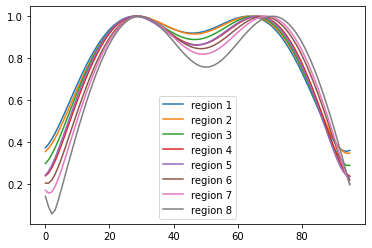

In [217]:
plt.plot(np.cos(h_s_ns)[0][0:96], label='region 1')
plt.plot(np.cos(h_s_ns)[1][0:96], label='region 2')
plt.plot(np.cos(h_s_ns)[2][0:96], label='region 3')
plt.plot(np.cos(h_s_ns)[3][0:96], label='region 4')
plt.plot(np.cos(h_s_ns)[4][0:96], label='region 5')
plt.plot(np.cos(h_s_ns)[5][0:96], label='region 6')
plt.plot(np.cos(h_s_ns)[6][0:96], label='region 7')
plt.plot(np.cos(h_s_ns)[7][0:96], label='region 8')
plt.legend()
plt.show()

太陽方位角, rad, 太陽方位角の正弦, 太陽方位角の余弦

In [218]:
sin_a_sun_ns = [solar_position._get_sin_a_sun_ns(delta_ns=delta_ns, h_sun_ns=h_s, omega_ns=omega, inzs=True) for (omega, h_s) in zip(omega_ns, h_s_ns)]
cos_a_sun_ns = [solar_position._get_cos_a_sun_ns(delta_ns=delta_ns, h_sun_ns=h_s, phi_loc=phi, inzs=True) for (h_s, phi) in zip(h_s_ns, phi_loc)]
a_s_ns = [solar_position._get_a_sun_ns(cos_a_sun_ns=cos_a_sun, sin_a_sun_ns=sin_a_sun, inzs=True) for (cos_a_sun, sin_a_sun) in zip(cos_a_sun_ns, sin_a_sun_ns)]

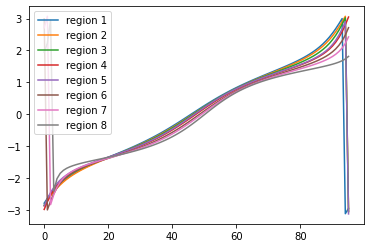

In [219]:
plt.plot(a_s_ns[0][0:96], label='region 1')
plt.plot(a_s_ns[1][0:96], label='region 2')
plt.plot(a_s_ns[2][0:96], label='region 3')
plt.plot(a_s_ns[3][0:96], label='region 4')
plt.plot(a_s_ns[4][0:96], label='region 5')
plt.plot(a_s_ns[5][0:96], label='region 6')
plt.plot(a_s_ns[6][0:96], label='region 7')
plt.plot(a_s_ns[7][0:96], label='region 8')
plt.legend()
plt.show()

In [220]:
omega_ns = solar_position._get_omega_ns(t_m_ns=t_m_ns, lambda_loc=lambda_loc, lambda_loc_mer=lambda_loc_mer, e_t_ns=e_t_ns)
omega_ns

array([[-3.00093867, -2.93548882, -2.87003898, ...,  3.08848813,
         3.15393798,  3.21938782],
       [-3.03793965, -2.9724898 , -2.90703996, ...,  3.05148715,
         3.116937  ,  3.18238684],
       [-3.04876069, -2.98331085, -2.917861  , ...,  3.04066611,
         3.10611596,  3.1715658 ],
       ...,
       [-3.17529706, -3.10984722, -3.04439737, ...,  2.91412974,
         2.97957959,  3.04502943],
       [-3.21893029, -3.15348045, -3.0880306 , ...,  2.87049651,
         2.93594635,  3.0013962 ],
       [-3.28411834, -3.21866849, -3.15321865, ...,  2.80530846,
         2.87075831,  2.93620815]])

太陽高度, rad * 8760 * 96

In [221]:
h_s_ns = solar_position._get_h_sun_ns(phi_loc, omega_ns, delta_ns)
h_s_2_ns = np.clip(h_s_ns, 0.0, None)

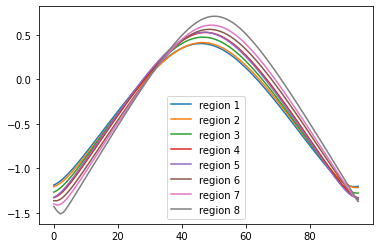

In [222]:
plt.plot(h_s_ns[0][0:96], label='region 1')
plt.plot(h_s_ns[1][0:96], label='region 2')
plt.plot(h_s_ns[2][0:96], label='region 3')
plt.plot(h_s_ns[3][0:96], label='region 4')
plt.plot(h_s_ns[4][0:96], label='region 5')
plt.plot(h_s_ns[5][0:96], label='region 6')
plt.plot(h_s_ns[6][0:96], label='region 7')
plt.plot(h_s_ns[7][0:96], label='region 8')
plt.legend()
plt.show()

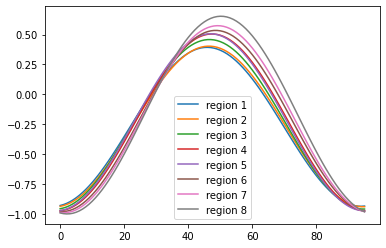

In [223]:
plt.plot(np.sin(h_s_ns)[0][0:96], label='region 1')
plt.plot(np.sin(h_s_ns)[1][0:96], label='region 2')
plt.plot(np.sin(h_s_ns)[2][0:96], label='region 3')
plt.plot(np.sin(h_s_ns)[3][0:96], label='region 4')
plt.plot(np.sin(h_s_ns)[4][0:96], label='region 5')
plt.plot(np.sin(h_s_ns)[5][0:96], label='region 6')
plt.plot(np.sin(h_s_ns)[6][0:96], label='region 7')
plt.plot(np.sin(h_s_ns)[7][0:96], label='region 8')
plt.legend()
plt.show()

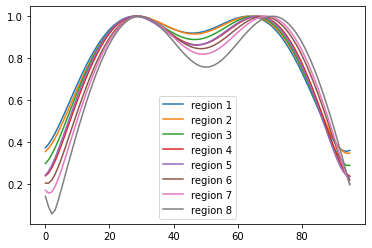

In [224]:
plt.plot(np.cos(h_s_ns)[0][0:96], label='region 1')
plt.plot(np.cos(h_s_ns)[1][0:96], label='region 2')
plt.plot(np.cos(h_s_ns)[2][0:96], label='region 3')
plt.plot(np.cos(h_s_ns)[3][0:96], label='region 4')
plt.plot(np.cos(h_s_ns)[4][0:96], label='region 5')
plt.plot(np.cos(h_s_ns)[5][0:96], label='region 6')
plt.plot(np.cos(h_s_ns)[6][0:96], label='region 7')
plt.plot(np.cos(h_s_ns)[7][0:96], label='region 8')
plt.legend()
plt.show()

太陽方位角, rad, 太陽方位角の正弦, 太陽方位角の余弦

In [225]:
sin_a_sun_ns = [solar_position._get_sin_a_sun_ns(delta_ns=delta_ns, h_sun_ns=h_s, omega_ns=omega, inzs=True) for (omega, h_s) in zip(omega_ns, h_s_ns)]
cos_a_sun_ns = [solar_position._get_cos_a_sun_ns(delta_ns=delta_ns, h_sun_ns=h_s, phi_loc=phi, inzs=True) for (h_s, phi) in zip(h_s_ns, phi_loc)]
a_s_ns = [solar_position._get_a_sun_ns(cos_a_sun_ns=cos_a_sun, sin_a_sun_ns=sin_a_sun, inzs=True) for (cos_a_sun, sin_a_sun) in zip(cos_a_sun_ns, sin_a_sun_ns)]


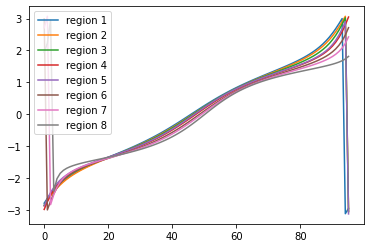

In [226]:
plt.plot(a_s_ns[0][0:96], label='region 1')
plt.plot(a_s_ns[1][0:96], label='region 2')
plt.plot(a_s_ns[2][0:96], label='region 3')
plt.plot(a_s_ns[3][0:96], label='region 4')
plt.plot(a_s_ns[4][0:96], label='region 5')
plt.plot(a_s_ns[5][0:96], label='region 6')
plt.plot(a_s_ns[6][0:96], label='region 7')
plt.plot(a_s_ns[7][0:96], label='region 8')
plt.legend()
plt.show()

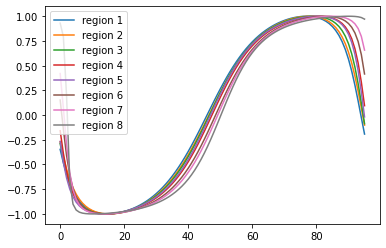

In [227]:
plt.plot(np.sin(a_s_ns[0])[0:96], label='region 1')
plt.plot(np.sin(a_s_ns[1])[0:96], label='region 2')
plt.plot(np.sin(a_s_ns[2])[0:96], label='region 3')
plt.plot(np.sin(a_s_ns[3])[0:96], label='region 4')
plt.plot(np.sin(a_s_ns[4])[0:96], label='region 5')
plt.plot(np.sin(a_s_ns[5])[0:96], label='region 6')
plt.plot(np.sin(a_s_ns[6])[0:96], label='region 7')
plt.plot(np.sin(a_s_ns[7])[0:96], label='region 8')
plt.legend()
plt.show()

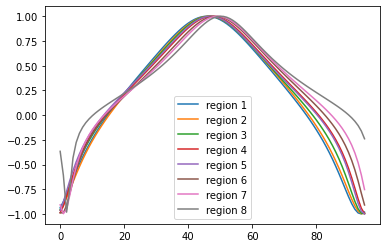

In [228]:
plt.plot(np.cos(a_s_ns[0])[0:96], label='region 1')
plt.plot(np.cos(a_s_ns[1])[0:96], label='region 2')
plt.plot(np.cos(a_s_ns[2])[0:96], label='region 3')
plt.plot(np.cos(a_s_ns[3])[0:96], label='region 4')
plt.plot(np.cos(a_s_ns[4])[0:96], label='region 5')
plt.plot(np.cos(a_s_ns[5])[0:96], label='region 6')
plt.plot(np.cos(a_s_ns[6])[0:96], label='region 7')
plt.plot(np.cos(a_s_ns[7])[0:96], label='region 8')
plt.legend()
plt.show()

